# 주택 가격 예측 : 회귀 문제
- 1970년 중반 보스턴 외곽지역의 범죄율
- 각 특성

## 보스턴 주택 데이터셋 불러오기

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

In [ ]:
train_targets # 개별적인 수치 데이터

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 준비
- 정규화하기 : 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 되므로 필요
- 왜 테스트 데이터에 train의 평균과 표준편차를 적용했는가? --> 공부하면 답변 가능
- Data Leakage 반드시 공부!!
  - 참조 : https://dschloe.github.io/python/machin_learning/ch03_data_preparation/

In [ ]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

## 모델 구성
- 샘플개수가 적기 때문에 2개의 중간

In [ ]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1)
  ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

## K-겹 검증을 사용한 훈련 검증

### k겹 검증

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print(f"#{i+1}번째 폴드 처리중")
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # 검증 데이터
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
      axis=0) # 훈련 데이터, 검증 데이터 외의 다른 부분
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
      axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=16, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

all_scores

#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중
#4번째 폴드 처리중


[2.0176501274108887, 2.477092981338501, 2.579883575439453, 2.331761121749878]

### 폴드의 검증 점수 저장

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"#{i}번째 폴드 처리중")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

#0번째 폴드 처리중
#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중


### 검증 점수 평균 기록

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 검증 점수 그래프 그리기

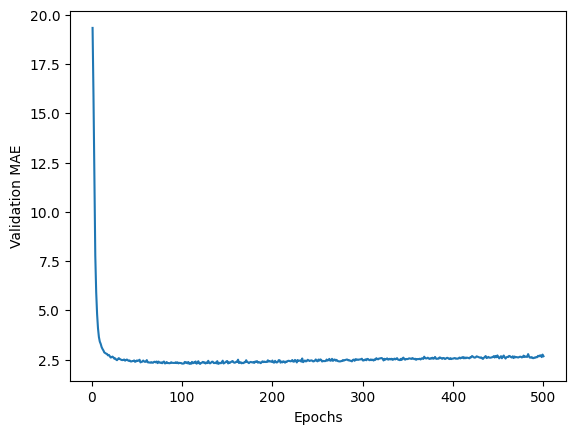

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### 처음 10개의 데이터 포인트를 제외한 검증 점수 그래프 그리기
- 그래프에서 위로 튀는 부분 이후로는 과적합 발생

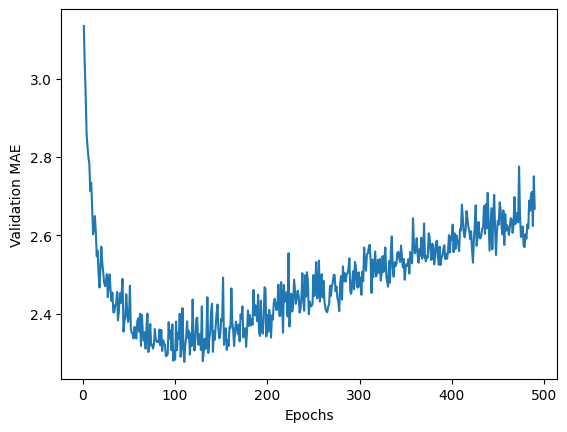

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()